In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
import time
from IPython.display import clear_output

In [ ]:
from d2l import torch as d2l
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

# ASTEROID

## DATA

In [ ]:
# get file names
galaxy = glob.glob('star-galaxy/galaxy/*')
star = glob.glob('star-galaxy/star/*')

# initialize arrays for images and labels
num_images = len(galaxy) + len(star)
images = []
labels = []

for x in galaxy:
    image = cv2.imread(x,1)
    image = np.array(image)
    images.append(image)
    labels.append(1)

for x in star:
    image = cv2.imread(x,1)
    image = np.array(image)
    images.append(image)
    labels.append(0)

images, labels= np.array(images), np.array(labels)
dataframe = pd.DataFrame(list(zip(images, labels)), columns=['images','labels'])

In [ ]:
dataframe['labels'].value_counts()

0    3044
1     942
Name: labels, dtype: int64

In [ ]:
# assume DataFrame
grouped = dataframe.groupby('labels')
# get 200 random samples from each group then Shuffle it data
data = grouped.apply(lambda x: x.sample(n=900)).sample(frac=1).reset_index(drop=True)
# Split data into train and test sets
train_data, test_data = train_test_split(data, test_size=0.3)

In [ ]:
train_data

,images,labels
230,"[[[85, 85, 85], [85, 85, 85], [110, 110, 110],...",1
559,"[[[60, 60, 60], [43, 43, 43], [115, 115, 115],...",1
1019,"[[[78, 78, 78], [79, 79, 79], [57, 57, 57], [8...",1
61,"[[[62, 62, 62], [49, 49, 49], [47, 47, 47], [4...",1
86,"[[[56, 56, 56], [80, 80, 80], [118, 118, 118],...",0
...,...,...
901,"[[[83, 83, 83], [77, 77, 77], [76, 76, 76], [9...",0
639,"[[[84, 84, 84], [56, 56, 56], [112, 112, 112],...",1
132,"[[[122, 122, 122], [80, 80, 80], [84, 84, 84],...",0
735,"[[[58, 58, 58], [43, 43, 43], [89, 89, 89], [4...",0


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        # self.transform = transform.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data.iloc[idx]['images']
        label = self.data.iloc[idx]['labels']
        transform = ToTensor()
        image = transform(image)
        return image, label

In [ ]:
train = CustomDataset(train_data)
test = CustomDataset(test_data)

## MODEL

### AlexNet Custom

In [ ]:

class AlexNet(nn.Module):
    def __init__(self, num_classes=2):
        super(AlexNet, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(64, 96, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(96, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))

        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(384 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes) #Softmax Classifier
        )
        self.fc = nn.Linear(384 * 6 * 6, num_classes) # Thay thế fully connected layer cuối cùng bằng SVM

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        # x = x.view(x.size(0), 12288)
        x = self.fc(x)
        return x


### VGG

nhiều tầng hơn hoặc bằng, nhưng kích thước của kernel giảm đi, hiệu quả hơn


In [ ]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        #Fully connected
        self.fc6 = nn.Linear(512 * 2 * 2, 4096)
        self.fc7 = nn.Linear(4096, 4096)
        self.fc8 = nn.Linear(4096, 2)
        #SVM
        self.fc = nn.Linear(512 * 2 * 2, 2) #num_classes

    def forward(self, x):
        x = nn.functional.relu(self.conv1_1(x))
        x = nn.functional.relu(self.conv1_2(x))
        x = self.pool1(x)
        x = nn.functional.relu(self.conv2_1(x))
        x = nn.functional.relu(self.conv2_2(x))
        x = self.pool2(x)
        x = nn.functional.relu(self.conv3_1(x))
        x = nn.functional.relu(self.conv3_2(x))
        x = nn.functional.relu(self.conv3_3(x))
        x = self.pool3(x)
        x = nn.functional.relu(self.conv4_1(x))
        x = nn.functional.relu(self.conv4_2(x))
        x = nn.functional.relu(self.conv4_3(x))
        x = self.pool4(x)
        x = nn.functional.relu(self.conv5_1(x))
        x = nn.functional.relu(self.conv5_2(x))
        x = nn.functional.relu(self.conv5_3(x))
        x = self.pool5(x)

        x = torch.flatten(x, 1)
        x = self.fc(x)

        # x = torch.flatten(x, 1)
        # x = nn.functional.relu(self.fc6(x))
        # x = nn.functional.relu(self.fc7(x))
        # x = self.fc8(x)

        return x


### GOOGLE NET

In [ ]:
class Inception(nn.Module):
    def __init__(self, in_channels, ch1x1, ch3x3reduce, ch3x3, ch5x5reduce, ch5x5, pool_proj):
        super(Inception, self).__init__()
        # 1x1 conv branch
        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels, ch1x1, kernel_size=1),
            nn.ReLU(inplace=True)
        )

        # 1x1 conv -> 3x3 conv branch
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, ch3x3reduce, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch3x3reduce, ch3x3, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        # 1x1 conv -> 5x5 conv branch
        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, ch5x5reduce, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch5x5reduce, ch5x5, kernel_size=5, padding=2),
            nn.ReLU(inplace=True)
        )

        # 3x3 pool -> 1x1 conv branch
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, pool_proj, kernel_size=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        branch1_output = self.branch1(x)
        branch2_output = self.branch2(x)
        branch3_output = self.branch3(x)
        branch4_output = self.branch4(x)
        outputs = [branch1_output, branch2_output, branch3_output, branch4_output]
        return torch.cat(outputs, 1)

class GoogleNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=2):
        super(GoogleNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        self.inception3a = Inception(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = Inception(256, 128, 128, 192, 32, 96, 64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.inception4a = Inception(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = Inception(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = Inception(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = Inception(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = Inception(528, 256, 160, 320, 32, 128, 128)
        self.inception5a = Inception(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = Inception(832, 384, 192, 384, 48, 128, 128)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool(x)
        x = self.inception4a(x)
        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        x = self.inception4e(x)
        x = self.maxpool(x)
        x = self.inception5a(x)
        x = self.inception5b(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)

        x = self.fc(x)
        return x


1x1x256 convolution operations
3x3x256 convolution operations
gradient vanish
GAP

## TRAIN

### custom train_ch6 with SGD

In [ ]:
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """Train a model with a GPU using PyTorch (defined in Chapter 6)."""
    net.to(device)
    optimizer = optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[0, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    start_time = time.time()

    train_loss = []
    train_acc = []
    test_acc = []
    n = len(train_iter)
    epoch_fracs = []
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples
        metric = d2l.Accumulator(3)
        for i, (X, y) in enumerate(train_iter):
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])

            end_time = time.time()
            if (i + 1) % 50 == 0:
                animator.add(epoch + i / n,
                             (train_loss, train_acc, None))
            train_loss.append(metric[0] / metric[2])
            train_acc.append(metric[1] / metric[2])
            test_acc.append(d2l.evaluate_accuracy_gpu(net, test_iter))
            # Update epoch_fracs
            epoch_fracs.append(epoch + i / n)

        # Plot train_loss and train_acc
        clear_output(wait=True)
        plt.plot(epoch_fracs, train_loss, label='train loss')
        plt.plot(epoch_fracs, train_acc, label='train acc')
        plt.plot(epoch_fracs, test_acc,label='test acc')
        plt.xlabel('Epoch')
        plt.ylabel('Value')
        plt.legend(loc='upper left')
        plt.pause(0.1)

    plt.show()
    print(f'Epoch {epoch}, train loss {train_loss[-1]:.3f}, train acc {train_acc[-1]:.3f}, '
        f'test acc {test_acc[-1]:.3f}')
    print(f"Training completed in {end_time - start_time:.2f}s")


### Training

In [ ]:
devices = [d for d in range(torch.cuda.device_count())]
device_names  = [torch.cuda.get_device_name(d) for d in devices]
device_names

['NVIDIA GeForce GTX 1650 Ti']

In [ ]:
train_dataloader = DataLoader(train, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test, batch_size=32, shuffle=False)

# Define model, loss function, and optimizer
loss_fn = nn.CrossEntropyLoss()
device = torch.device("cuda:0")
lr, num_epochs = 0.05, 20

In [ ]:
# for id, (a,b) in enumerate(train_dataloader):
#     print(id, a, b)

loss 0.431, train acc 0.806, test acc 0.719
1295.2 examples/sec on cuda:0


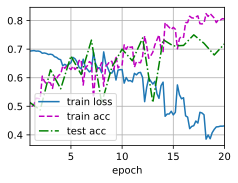

In [ ]:
#Alexnet (good with lr 0.005)
model = AlexNet(num_classes=2)
d2l.train_ch6(model, train_dataloader, test_dataloader, num_epochs, lr, device)

fine tunning

In [ ]:
#VGG
model = VGG()
d2l.train_ch6(model, train_dataloader, test_dataloader, 10, 0.002, device)

In [ ]:
#GGnet with custom ch6
model = GoogleNet()
train_ch6(model, train_dataloader, test_dataloader, num_epochs, lr, device)

# REFERENCE

- https://aicurious.io/blog/2019-09-23-cac-ham-kich-hoat-activation-function-trong-neural-networks
- https://d2l.aivivn.com/chapter_convolutional-modern/alexnet_vn.html#doc-tap-du-lieu
- https://d2l.aivivn.com/chapter_convolutional-modern/vgg_vn.html?highlight=vgg
- https://proceedings.neurips.cc/paper_files/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf

data
- https://www.kaggle.com/code/sathvikvadarevu/supervised-ml-algorithms

thay fully connected bằng SVM, rút trích đặc trưng

In [ ]:
def testData(train_dataset,test_dataset,epoch,title,usePreTrain=True):
  seed_value = 42
  torch.manual_seed(seed_value)
  #grouped = dataframe.groupby('labels')
  #_data = grouped.apply(lambda x: x).reset_index(drop=True)
  #train_data, test_data = train_test_split(_data,random_state =seed_value, test_size=0.3)
  train = CustomDataset(train_dataset)
  test = CustomDataset(test_dataset)
  train_dataloader = DataLoader(train, batch_size=32, shuffle=True)
  test_dataloader = DataLoader(test, batch_size=32, shuffle=False)


  # Define model, loss function, and optimizer
  loss_fn = nn.CrossEntropyLoss()
  device = torch.device("cuda:0")
  lr, num_epochs = 0.05, 20
  if usePreTrain==True:
    vgg16 = models.vgg16()
  else:
    vgg16 = models.vgg16(pretrained=False)

  # Define a loss function
  vgg16.to(device)
  criterion = nn.CrossEntropyLoss()


  # Define an optimizer
  optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

  # Loop through the data and train the model
  for epoch in range(epoch):
      running_loss=0
      for i, data in enumerate(train_dataloader, 0):
          # Get the inputs and labels
          inputs, labels = data

          # Zero the parameter gradients
          optimizer.zero_grad()

          # Forward pass
          inputs, labels = inputs.to(device), labels.to(device)
          outputs = vgg16(inputs)

          # Compute the loss
          loss = criterion(outputs, labels)

          # Backward pass
          loss.backward()

          # Update weights
          optimizer.step()

  #get Accuracy
  correct = 0
  total = 0
  with torch.no_grad():
      for data in test_dataloader:
          inputs, labels = data
          inputs = inputs.to(device)
          labels = labels.to(device)
          outputs = vgg16(inputs)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  accuracy = 100 * correct / total
  print('Accuracy of the network on the test images: %d %%' % accuracy)
  f1(vgg16, test_dataloader,title)